Install Required Libraries

In [ ]:
!pip install ucimlrepo pandas numpy matplotlib seaborn scikit-learn tensorflow xgboost

Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from ucimlrepo import fetch_ucirepo

Fetch Dataset

In [ ]:
# Fetch dataset
metro_interstate_traffic_volume = fetch_ucirepo(id=492)

# Features and target
X = metro_interstate_traffic_volume.data.features
y = metro_interstate_traffic_volume.data.targets

# Combine features and target for EDA
data = pd.concat([X, y], axis=1)

Display Dataset Information

In [ ]:
print(metro_interstate_traffic_volume.metadata)
print(metro_interstate_traffic_volume.variables)

{'uci_id': 492, 'name': 'Metro Interstate Traffic Volume', 'repository_url': 'https://archive.ics.uci.edu/dataset/492/metro+interstate+traffic+volume', 'data_url': 'https://archive.ics.uci.edu/static/public/492/data.csv', 'abstract': 'Hourly Minneapolis-St Paul, MN traffic volume for westbound I-94. Includes weather and holiday features from 2012-2018.', 'area': 'Other', 'tasks': ['Regression'], 'characteristics': ['Multivariate', 'Sequential', 'Time-Series'], 'num_instances': 48204, 'num_features': 8, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': ['traffic_volume'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2019, 'last_updated': 'Fri Mar 15 2024', 'dataset_doi': '10.24432/C5X60B', 'creators': ['John Hogue'], 'intro_paper': None, 'additional_info': {'summary': 'Hourly Interstate 94 Westbound traffic volume for MN DoT ATR station 301, roughly midway between Minneapolis and St Paul, MN. Hourly weath

Check for Missing Values

In [ ]:
print(data.isnull().sum())

holiday                48143
temp                       0
rain_1h                    0
snow_1h                    0
clouds_all                 0
weather_main               0
weather_description        0
date_time                  0
traffic_volume             0
dtype: int64


In [ ]:

data['holiday'] = data['holiday'].fillna('None')

Handle Missing Values

In [ ]:
# Handle Missing Values for numeric columns only
for column in data.select_dtypes(include=np.number).columns:
    data.loc[:, column] = data[column].fillna(data[column].median())

In [ ]:
print(data.isnull().sum())

holiday                0
temp                   0
rain_1h                0
snow_1h                0
clouds_all             0
weather_main           0
weather_description    0
date_time              0
traffic_volume         0
dtype: int64


Exploratory Data Analysis (EDA) - Summary Statistics

In [ ]:
print(data.describe())

               temp       rain_1h       snow_1h    clouds_all  traffic_volume
count  48204.000000  48204.000000  48204.000000  48204.000000    48204.000000
mean     281.205870      0.334264      0.000222     49.362231     3259.818355
std       13.338232     44.789133      0.008168     39.015750     1986.860670
min        0.000000      0.000000      0.000000      0.000000        0.000000
25%      272.160000      0.000000      0.000000      1.000000     1193.000000
50%      282.450000      0.000000      0.000000     64.000000     3380.000000
75%      291.806000      0.000000      0.000000     90.000000     4933.000000
max      310.070000   9831.300000      0.510000    100.000000     7280.000000


EDA - Traffic Volume Distribution

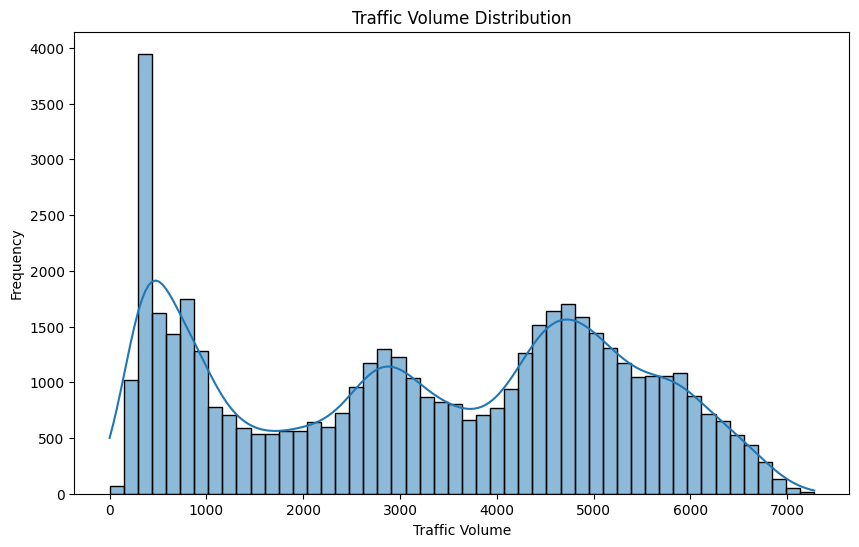

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data['traffic_volume'], bins=50, kde=True)
plt.title('Traffic Volume Distribution')
plt.xlabel('Traffic Volume')
plt.ylabel('Frequency')
plt.show()

EDA - Correlation Heatmap

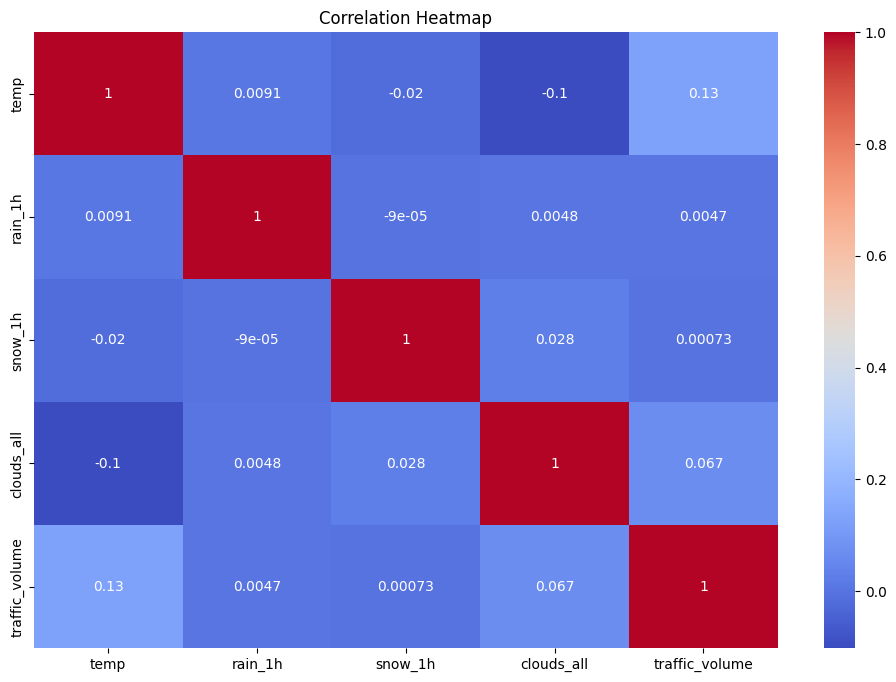

In [ ]:
plt.figure(figsize=(12, 8))
# Calculate correlation only for numeric columns
numeric_data = data.select_dtypes(include=np.number)
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

As dataset seems too much imbalanced and missing values we will now clean it

Feature Engineering - Extract Time-Based Features

In [ ]:
data['date_time'] = pd.to_datetime(data['date_time'])
data['hour'] = data['date_time'].dt.hour
data['day_of_week'] = data['date_time'].dt.dayofweek
data['month'] = data['date_time'].dt.month

Feature Engineering - Encode Categorical Variables

In [ ]:
data = pd.get_dummies(data, columns=['weather_main', 'holiday'], drop_first=True)

Drop Unnecessary Columns

In [ ]:
data.drop(['date_time'], axis=1, inplace=True)

 Split Data into Training and Testing Sets

In [ ]:
X = data.drop('traffic_volume', axis=1)
y = data['traffic_volume']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Normalize Numerical Features

In [ ]:
metro_interstate_traffic_volume = fetch_ucirepo(id=492)
X = metro_interstate_traffic_volume.data.features
# The target variable 'y' should be assigned to the 'targets' attribute.
y = metro_interstate_traffic_volume.data.targets
data = pd.concat([X, y], axis=1)
encoded_data = pd.get_dummies(data, columns=['weather_main', 'holiday', 'weather_description'], drop_first=True)
encoded_data.drop(['date_time'], axis=1, inplace=True)
#  Split Data into Training and Testing Sets
X = encoded_data.drop('traffic_volume', axis=1)
y = encoded_data['traffic_volume']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize Numerical Features
# Now apply StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
data['holiday'] = data['holiday'].fillna('None')

In [ ]:
data['date_time'] = pd.to_datetime(data['date_time'])
data['hour'] = data['date_time'].dt.hour
data['day_of_week'] = data['date_time'].dt.dayofweek  # 0: Monday, 6: Sunday
data['month'] = data['date_time'].dt.month

In [ ]:
data = pd.get_dummies(data, columns=['weather_main', 'weather_description', 'holiday'], drop_first=True)

In [ ]:
data.head()

,temp,rain_1h,snow_1h,clouds_all,date_time,traffic_volume,hour,day_of_week,month,weather_main_Clouds,...,holiday_Independence Day,holiday_Labor Day,holiday_Martin Luther King Jr Day,holiday_Memorial Day,holiday_New Years Day,holiday_None,holiday_State Fair,holiday_Thanksgiving Day,holiday_Veterans Day,holiday_Washingtons Birthday
0,288.28,0.0,0.0,40,2012-10-02 09:00:00,5545,9,1,10,True,...,False,False,False,False,False,True,False,False,False,False
1,289.36,0.0,0.0,75,2012-10-02 10:00:00,4516,10,1,10,True,...,False,False,False,False,False,True,False,False,False,False
2,289.58,0.0,0.0,90,2012-10-02 11:00:00,4767,11,1,10,True,...,False,False,False,False,False,True,False,False,False,False
3,290.13,0.0,0.0,90,2012-10-02 12:00:00,5026,12,1,10,True,...,False,False,False,False,False,True,False,False,False,False
4,291.14,0.0,0.0,75,2012-10-02 13:00:00,4918,13,1,10,True,...,False,False,False,False,False,True,False,False,False,False


In [ ]:
data.drop(['date_time'], axis=1, inplace=True)

In [ ]:
from sklearn.preprocessing import StandardScaler

# Separate features (X) and target (y)
X = data.drop('traffic_volume', axis=1)
y = data['traffic_volume']

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler to the features and transform them
X_scaled = scaler.fit_transform(X)

# Convert the scaled features back to a DataFrame
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

Model 1 Random Forest Model


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
print('Random Forest MAE:', mean_absolute_error(y_test, y_pred))
print('Random Forest RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('Random Forest R2:', r2_score(y_test, y_pred))

Random Forest MAE: 255.65540887874698
Random Forest RMSE: 459.89892285625933
Random Forest R2: 0.9465015065501668


Evaluate Random Forest Model

XGBoost Model

In [ ]:
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

In [ ]:
print('XGBoost MAE:', mean_absolute_error(y_test, y_pred_xgb))
print('XGBoost RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print('XGBoost R2:', r2_score(y_test, y_pred_xgb))

XGBoost MAE: 259.28033447265625
XGBoost RMSE: 447.0364218942345
XGBoost R2: 0.9494521617889404


Hyperparameter tuning

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=XGBRegressor(random_state=42),
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=5,
                           verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Train the model with the best parameters
best_xgb_model = XGBRegressor(**best_params, random_state=42)
best_xgb_model.fit(X_train, y_train)

# Evaluate the model
y_pred_xgb = best_xgb_model.predict(X_test)
print('XGBoost MAE:', mean_absolute_error(y_test, y_pred_xgb))
print('XGBoost RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print('XGBoost R2:', r2_score(y_test, y_pred_xgb))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.4s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.4s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.4s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.4s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.4s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.6s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.6s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.6s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.6s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.6s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.9s
[CV] END ..learning_rate=0.01, max_depth=3, n_e

LSTM Model Preparation

In [ ]:
X_train_lstm = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

Build LSTM Model

In [ ]:
from tensorflow.keras.layers import Input
# Build LSTM Model
lstm_model = Sequential()
lstm_model.add(Input(shape=(1, X_train.shape[1])))
lstm_model.add(LSTM(50, activation='relu'))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')


Train LSTM Model

In [ ]:
history = lstm_model.fit(X_train_lstm, y_train, epochs=50, validation_split=0.2, verbose=1)

Plot LSTM Training Loss

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Evaluate LSTM Model

In [ ]:
y_pred_lstm = lstm_model.predict(X_test_lstm)
print('LSTM MAE:', mean_absolute_error(y_test, y_pred_lstm))
print('LSTM RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_lstm)))
print('LSTM R2:', r2_score(y_test, y_pred_lstm))

Compare Model Performance

In [ ]:
models = ['Random Forest', 'XGBoost', 'LSTM']
mae_scores = [mean_absolute_error(y_test, y_pred), mean_absolute_error(y_test, y_pred_xgb), mean_absolute_error(y_test, y_pred_lstm)]
plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=mae_scores)
plt.title('Model Comparison - MAE')
plt.xlabel('Model')
plt.ylabel('MAE')
plt.show()

Feature Importance - Random Forest

In [ ]:
importances = rf_model.feature_importances_
feature_names = X.columns
plt.figure(figsize=(12, 8))
sns.barplot(x=importances, y=feature_names)
plt.title('Feature Importance - Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()